In [8]:
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from torchsummary import summary
from tqdm import tqdm

In [9]:
#global variable for training
#you just use the following hyper-parameters
BATCH_SIZE = 100
NUM_EPOCHS = 2
LEARNING_RATE = 0.01
CRITERION= nn.CrossEntropyLoss()

In [10]:
# CIFAR10 Dataset
train_dataset = dsets.CIFAR10(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = dsets.CIFAR10(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)



100%|██████████| 170498071/170498071 [00:03<00:00, 49006574.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

1
(32, 32, 3)


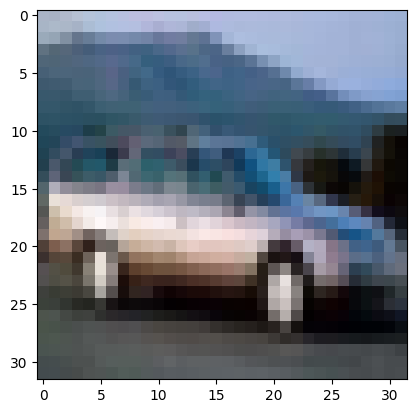

In [ ]:
train_dataset.class_to_idx
index= 4
print(train_dataset.targets[index])
print(train_dataset.data[index].shape)
plt.imshow(train_dataset.data[index])

In [11]:
def fit(model,train_loader):
  # 1 epoch training
  model.train()
  device = next(model.parameters()).device.index #GPU인지 CPU인지 추론 하는 거 같은거
  optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
  losses= []
  for i, data in enumerate(train_loader):
    image = data[0].type(torch.FloatTensor).cuda(device)
    label = data[1].type(torch.LongTensor).cuda(device)

    pred_label = model(image)
    loss = CRITERION(pred_label, label)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  avg_loss = sum(losses)/len(losses)
  return avg_loss


In [12]:
def eval(model, test_loader):
  model.eval()
  device = next(model.parameters()).device.index
  pred_labels = []
  real_labels = []

  for i, data in enumerate(test_loader):
    image = data[0].type(torch.FloatTensor).cuda(device)
    label = data[1].type(torch.LongTensor).cuda(device)
    real_labels += list(label.cpu().detach().numpy())
    #detach는 gpu위에 이는 pytotch를 numpy로 바꾸기 위한 것임


    pred_label = model(image)
    pred_label = list(pred_label.cpu().detach().numpy())
    pred_labels += pred_label

  real_labels= np.array(real_labels)
  pred_labels = np.array(pred_labels)
  pred_labels = pred_labels.argmax(axis=1)
  #argmax 하는 과정은 10개의 클래스의 확률을 output으로
  #내는 과정을 1개의 최대 값을 배출 하는 과정을 나는 내는 것임

  acc = sum(real_labels == pred_labels)/len(real_labels)*100

  return acc

# Task1: Compare between simple MLP and simple CNN

MLP

In [ ]:
class SImpleMLP(nn.Module):
  def __init__(self):
    super(SImpleMLP, self).__init__()
    #FULLY-connceted layer)
    self.fc1_1 = nn.Linear(3*32*32, 8*28*28)
    self.act1_1 = nn.ReLU()
    self.fc1_2 = nn.Linear(8*28*28, 8*24*24)
    self.act1_2 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2)

    self.fc2_1 = nn.Linear(8*12*12, 16*8*8)
    self.act2_1 = nn.ReLU()
    self.fc2_2 = nn.Linear(16*8*8, 16*4*4)
    self.act2_2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(2)

    self.out = nn.Linear(16*2*2, 10)

  def forward(self, x):
    x = x.view(-1, 3*32*32)

    x = self.act1_1(self.fc1_1(x))
    x = self.act1_2(self.fc1_2(x))
    x = x.view(-1,8,24,24)
    x= self.pool1(x)
    x = x.view(-1, 8*12*12)

    x = self.act2_1(self.fc2_1(x))
    x = self.act2_2(self.fc2_2(x))
    x = x.view(-1,16,4,4)
    x= self.pool2(x)
    x = x.view(-1, 16*2*2)

    out = self.out(x)
    return out

In [ ]:
mlp_model = SImpleMLP().cuda()
train_loss1 = []
test_accuracy1 = []
for epoch in tqdm(range(NUM_EPOCHS)):
  #시간들을 bar 형태로 보여주는 것
  train_loss1.append(fit(mlp_model, train_loader))
  test_accuracy1.append(eval(mlp_model, test_loader))

summary(mlp_model, input_size= (3, 32, 32))
#layer별로 파라미터를 보여 주는 것

100%|██████████| 2/2 [00:20<00:00, 10.44s/it]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 6272]      19,273,856
              ReLU-2                 [-1, 6272]               0
            Linear-3                 [-1, 4608]      28,905,984
              ReLU-4                 [-1, 4608]               0
         MaxPool2d-5            [-1, 8, 12, 12]               0
            Linear-6                 [-1, 1024]       1,180,672
              ReLU-7                 [-1, 1024]               0
            Linear-8                  [-1, 256]         262,400
              ReLU-9                  [-1, 256]               0
        MaxPool2d-10             [-1, 16, 2, 2]               0
           Linear-11                   [-1, 10]             650
Total params: 49,623,562
Trainable params: 49,623,562
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Fo

In [ ]:
train_loss1, test_accuracy1

([1.9416428534984589, 1.6798721625804902], [37.24, 42.22])

CNN

TAsk 2:VGG

VGG

In [ ]:
import torch.utils.model_zoo as model_zoo

model_urls = {
    "vgg11": "https://download.pytorch.org/models/vgg11-bbd30ac9.pth",
    "vgg13": "https://download.pytorch.org/models/vgg13-c768596a.pth",
    "vgg16": "https://download.pytorch.org/models/vgg16-397923af.pth",
    "vgg19": "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth",
    "vgg11_bn": "https://download.pytorch.org/models/vgg11_bn-600",
    "vgg13_bn": "https://download.pytorch.org/models/vgg13_bn-abd245e",
    "vgg16_bn": "https://download.pytorch.org/models/vgg16_bn-6c6",
    "vgg19_bn": "https://download.pytorch.org/models/vgg19_bn-c794",
    }


In [ ]:
class VGG(nn.Module):

  def __init__(self, features, num_classes=1000, init_weights=True):
    super(VGG, self).__init__()
    self.features = features
    #feature extractor: convolutional filter의 뭉치.
    #feature extractor : convolutional filter의 뭉치. nn.conv2d, nn.batchnorm, .. nn.linear)
    self.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, num_classes),
    )   #sequentail을 만들면 한번에 써줄 수 있음 !!
    if init_weights:
      self._initialize_weights()

  def forward(self, x):
    x = self.features(x) #batch size X 512 X 7 x/7
    x = x.view(x.size(0), -1) #x.size(0) = batch size X (512*7*&7)
    #view는 텐서의 크기를 변경하는데 사용되는 것임
    #첫 번째 차원은 그대로 두고 나머지 차원들을 하나로 평탄화하는 작업

    x = self.classifier(x)
    return x

  def _initialize_weights(self):
    for m in self.modules():
      #여기서 말하는 모듈은 feature를 뜻함. nn.~~~
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        #kalming initialization
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

def make_layers(cfg, batch_norm=False):
         # config : ditionary 기반으로 encoding 하는 것
         #network 정보들을 저장해놓은 것을 통상적으로 부름
    layers= []
    in_channels = 3
    for v in cfg:
      if v == 'M':
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
      else:
        conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
        #batch_norm이 있으면 batchnorm을 추가하고
        #아니면 그냥 conv와 ReLU 함수를 진행 함.
        if batch_norm:
          layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
        else:
          layers += [conv2d, nn.ReLU(inplace=True)]
        in_channels = v
    return nn.Sequential(*layers)

cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512,512, 'M'],
    #output channel 수 , M은 maxpool을 의미함
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'C': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512,512, 'M', 512, 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    }

def vgg11(pretrained=False, **kwargs):
    if pretrained:
      kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['A']), **kwargs)
    if pretrained:
      model.load_state_dict(model_zoo.load_url(model_urls['vgg11']))
    return model

def vgg11_bn(pretrained=False, **kwargs):
    if pretrained:
      kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['A'], batch_norm=True), **kwargs)
    if pretrained:
      model.load_state_dict(model_zoo.load_url(model_urls['vgg11_bn']))
    return model


def vgg13(pretrained=False, **kwargs):
    if pretrained:
      kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['B']), **kwargs)
    if pretrained:
       model.load_state_dict(model_zoo.load_url(model_urls['vgg13']))
    return model

def vgg13_bn(pretrained=False, **kwargs):
    if pretrained:
      kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['B'], batch_norm=True), **kwargs)
    if pretrained:
      model.load_state_dict(model_zoo.load_url(model_urls['vgg13_bn']))
    return model

def vgg16(pretrained=False, **kwargs):
    '''VGG 16-layer model (configuration "D")
      Args:
          pretrained (bool): if True, returns a model pre-trained on ImageNet'''
    if pretrained:
      kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['D']), **kwargs)
    if pretrained:
      model.load_state_dict(model_zoo.load_url(model_urls['vgg16']))
    return model

def vgg16_bn(pretrained=False, **kwargs):
    '''VGG 16-layer model (configuration "D")
      Args:
          pretrained (bool): if True, returns a model pre-trained on ImageNet'''
    if pretrained:
      kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['D'], batch_norm=True), **kwargs)
    if pretrained:
      model.load_state_dict(model_zoo.load_url(model_urls['vgg16_bn']))
    return model

def vgg19(pretrained=False, **kwargs):
    '''VGG 19-layer model (configuration "E")
      Args:
          pretrained (bool): if True, returns a model pre-trained on ImageNet'''
    if pretrained:
      kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['E']), **kwargs)
    if pretrained:
      model.load_state_dict(model_zoo.load_url(model_urls['vgg19']))
    return model

def vgg19_bn(pretrained=False, **kwargs):
    '''VGG 19-layer model (configuration 'E')
      Args:
          pretrained (bool): if True, returns a model pre-trained on ImageNet'''
    if pretrained:
     kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['E'], batch_norm=True), **kwargs)
    if pretrained:
      model.load_state_dict(model_zoo.load_url(model_urls['vgg19_bn']))
    return model



In [ ]:
vgg_model = vgg11_bn(num_classes=10).cuda()
train_loss3 = []
test_accuracy3 = []
for epoch in tqdm(range(NUM_EPOCHS)):
  #시간들을 bar 형태로 보여주는 것
  train_loss3.append(fit(mlp_model, train_loader))
  test_accuracy3.append(eval(mlp_model, test_loader))


100%|██████████| 2/2 [00:21<00:00, 10.74s/it]


In [ ]:
!nvidia-smi

Sat Jul 20 10:30:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0              32W /  70W |   1529MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Task 3 : ResNet

In [15]:
'''
ResNet in PyTorch.
For Pre-activaition ResNet, see 'preact_resnet.py'.
Referenc:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''

import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1): #inplane = input channels
                                                   #plane = output channels
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
      #일반적으로는 convolutional 넘어간 것에 x를 붙임.
      #그러나 shortcut을 해야할 때가 있음. stride가 1이 아니거나 input값이 다른 경우
    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out


class Bottleneck(nn.Module):
  expansion = 4
#convolutional 층을 3개를 만들고 batchnorm까지 진행한 후에 +selfcut을 넣고 relu를 진행하는 형태임.
  def __init__(self, in_planes, planes, stride=1):
    super(Bottleneck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)

    self.bn2 - nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)
    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self,block,planes, num_blocks, stride):
    #stride를 제외한 나머지 블락은 1로 채우는 것임,
    strides = [stride] + [1]*(num_blocks-1)
    layers= []
    for stride in strides:
        layers.append(block(self.in_planes, planes, stride))
        self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4) #batch_size x 512 x 1 x 1
    out = out.view(out.size(0), -1) #flatten 하는 과정
    out = self.linear(out)
    return out

def ResNet18():
  return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50(): #50 부터는 bottleneck을 주로 사용함
                   #block layer는 논문에 구현 되어 있는 수치임
    return ResNet(Bottleneck, [3,4,6,3])


def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def Resnet152():
    return ResNet(Bottleneck, [3,8,36,3])

def test():
    net = ResNet19()
    y= net(torch.randn(1,3,32,32))
    print(y.size())



In [16]:
resnet_model = ResNet18().cuda()
train_loss4 = []
test_accuracy4 = []
for epoch in tqdm(range(NUM_EPOCHS)):
  #시간들을 bar 형태로 보여주는 것
  train_loss4.append(fit(resnet_model, train_loader))
  test_accuracy4.append(eval(resnet_model, test_loader))

100%|██████████| 2/2 [01:33<00:00, 46.95s/it]


In [18]:
print(train_loss4)
print(test_accuracy4)

[1.274281534433365, 0.732148706138134]
[62.4, 69.57]


# Task 4 : MobileNet

In [28]:
import torch

# 이전 가져오기를 새 가져오기로 바꿉니다.
# from torchvision.models.utils import load_state_dict_from_url
load_state_dict_from_url = torch.hub.load_state_dict_from_url

In [72]:
class ConvBNReLU(nn.Module):
  def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1, bn_aff= True):
    padding = (kernel_size -1) // 2
    super(ConvBNReLU, self).__init__()
    self.conv= nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False)
    self.bn = nn.BatchNorm2d(out_planes,affine= bn_aff)
    self.relu= nn.ReLU6(inplace=True)

  def forward(self, x):
    x= self.conv(x)
    x=self.bn(x)
    x= self.relu(x)
    return x



In [73]:
#pointwise - BN-depthwise -BN=relu6 - pointwise - bn

class invertedResiudal(nn.Module):
  def __init__(self, inp, oup, stride, expand_ratio, shortcut, bn_aff):
    super(invertedResiudal, self).__init__()
    self.shortcut = shortcut
    self.bn_aff = bn_aff
    self.stride= stride
    assert stride in [1,2]

    hidden_dim = int(round(inp * expand_ratio))
    self.use_res_connect = self.stride == 1 and inp == oup

    layers = []
    if expand_ratio != 1:
      #pw:
      layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1, bn_aff=self.bn_aff))
    layers.extend([
        #dw : featur map 의  out channels 는 hodden_dim
        ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim, bn_aff=bn_aff),
        #pw-linear squeeze #kernal size -stride -padding
        nn.Conv2d(hidden_dim, oup, kernel_size=1),
        nn.BatchNorm2d(oup, affine=self.bn_aff)
    ])
    self.conv = nn.Sequential(*layers)

  def forward(self, x):
    if self.use_res_connect:
      if self.shortcut:
        return x + self.conv(x)
      else:
        return self.conv(x)
    else:
        return self.conv(x)

In [74]:
model_urls= {
    'mobilenet_v2': 'https://download.pytorch.org/models/mobilenet_v2-b0353104.pth',
}
def _make_divisible(x, divisible_by=8):
  import numpy as np
  return int(np.ceil(x*1. / divisible_by)* divisible_by)

class MobileNetV2(nn.Module):
  def __init__(self, num_classes=1000, width_mult=1.0, inverted_residual_setting=None, round_nearest=8
              ,block=None, shortcut = True, bn_aff=True):
    super(MobileNetV2, self).__init__()

    if block is None:
      block = invertedResiudal
    input_channel = 32
    last_channel = 1280
    self.bn_aff = bn_aff
    self.shortcut = shortcut

    if inverted_residual_setting is None:
      inverted_residual_setting = [
          # t(expansion rate), c(outputchanel), n(blocks),s(stride)
          [1, 16, 1, 1],
          [6, 24, 2, 2], #stride 2가 2개 나오는게 아니라 마지막에  1개만 나옴
                         #[16-96-24] -[16-96-24] 과정이두번 나옴 #laber intensive
           [6, 32, 3, 2],
          [6, 64, 4, 2],

      ]

    if len(inverted_residual_setting) == 0 or len(inverted_residual_setting)!=4:
      raise ValueError('inverted_residual_setting should be non-empty or a 4-element list')

    # building first layer
    input_channel = _make_divisible(input_channel * width_mult, round_nearest)
    self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
    features = [ConvBNReLU(3, input_channel, stride=2, bn_aff=self.bn_aff)]

    #building inverted residual blocks
    for t,c,n,s in inverted_residual_setting:
      output_channel = _make_divisible(c * width_mult, round_nearest)
      for i in range(n):
          stride = s if i == 0 else 1
          features.append(block(input_channel,output_channel,stride, expand_ratio=t,
                                shortcut = self.shortcut, bn_aff=self.bn_aff))
          input_channel = output_channel

    #building test several layers
    features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1, bn_aff=self.bn_aff))

   #make it nn.Sequential
    self.features = nn.Sequential(*features)

   #building classifier
    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(self.last_channel, num_classes),
    )

   # weight initialization
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', )
        if m.bias is not None:
          nn.init.zeros_(m.bias)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.zeros_(m.bias)

  def _forward_impl(self, x):

      x=self.features(x)
      x=nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0],-1)
      x=self.classifier(x)
      return x

  def forward(self, x):
      return self._forward_impl(x)




In [75]:
def mobilenet_v2(pretrained=False, progress=True, **kwargs):

  model = MobileNetV2(**kwargs)
  if pretrained:
    state_dict = load_state_dict_from_url(model_urls['mobilenet_v2'],
                                          progress=progress)
    model.load_state_dict(state_dict)
  return model

In [77]:
resnet_bn_model = mobilenet_v2(num_classes=10).cuda()
train_loss5=[]
test_accuracy5=[]
for epoch in tqdm(range(NUM_EPOCHS)):
  #시간들을 bar 형태로 보여주는 것
  train_loss5.append(fit(resnet_bn_model, train_loader))
  test_accuracy5.append(eval(resnet_bn_model, test_loader))

100%|██████████| 2/2 [00:31<00:00, 15.60s/it]


In [78]:
print (train_loss5)
print(test_accuracy5)

[1.701685840845108, 1.339791757941246]
[46.410000000000004, 56.18]
